In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [17]:
from CALIBRATION import filedata, readfiles,ScatterPlotVariables, ScatterPlotVariablesperday, LinearRegressionModel, PolynomialRegressionModel,  HuberRegressionModel
file_CO = filedata('2019-08-15-CO-Final.xlsx', 'Base')
# Read data from fike
day, X, y, dataframe = readfiles(file_CO)

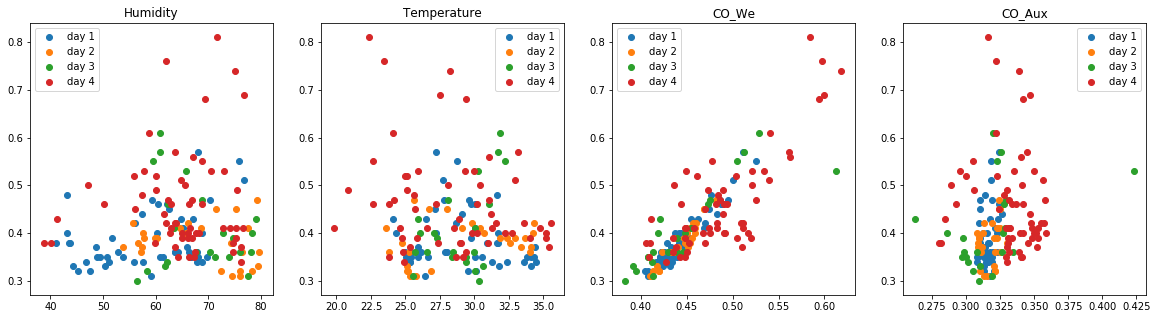

In [20]:
ScatterPlotVariablesperday(day, X,y,dataframe.columns[1:-1]);  plt.show()

,Day,Humidity,Temperature,CO_We,CO_Aux,CO ppm
Day,1.000000,0.252413,-0.085181,0.408072,0.363905,0.376871
Humidity,0.252413,1.000000,-0.489673,0.162559,0.269358,0.106727
Temperature,-0.085181,-0.489673,1.000000,0.129629,0.183460,-0.122992
CO_We,0.408072,0.162559,0.129629,1.000000,0.609250,0.860494
CO_Aux,0.363905,0.269358,0.183460,0.609250,1.000000,0.219366
CO ppm,0.376871,0.106727,-0.122992,0.860494,0.219366,1.000000


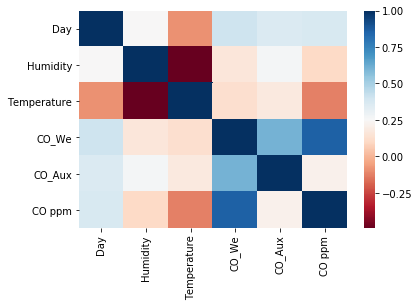

In [22]:
# Check multicollinerity

# Calculate the correlation matrix
corr = dataframe.corr()
display(corr)
# correlation heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')
# Scatter plot for multicollinearity
#pd.plotting.scatter_matrix(dataframe, alpha=1, figsize = (30,20))
#plt.show()

## Select day 4

In [8]:
dataframe = dataframe[dataframe['Day']==4]
dataframe_before = dataframe
#dataframe_after = dataframe
dataframe_after = dataframe.drop(['Day'], axis=1)

#X1 = sm.tools.add_constant(dataframe_before)
#X2 = sm.tools.add_constant(dataframe_after)

#series_before = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])],index = X1.columns)
#series_after = pd.Series([variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])],index = X2.columns)

#print("DATA BEFORE")
#print('-'*100)
#display(series_before)

#print("DATA AFTER")
#print('-'*100)
#display(series_after)

In [9]:
# Describe de data set
#desc_df = dataframe.describe()

#desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*3)
#desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*3)

#desc_df


In [25]:
# Removing outliers using zscore
dataframe_remove = dataframe_after[(np.abs(stats.zscore(dataframe_after)) < 3).all(axis = 1)]
dataframe_after.index.difference(dataframe_remove.index)

Int64Index([148, 156], dtype='int64')

# Linear Regression model

In [26]:
# Build the model using sklearn
X = dataframe_remove.drop('CO ppm', axis=1)
y = dataframe_remove['CO ppm']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 1)

# Create Linear Regression model object
model_lin_reg = LinearRegression()
model_lin_reg.fit(X_train, y_train)

intercept = model_lin_reg.intercept_
coefficient = model_lin_reg.coef_

print("The intercept of our linear regression model is {:.5f}".format(intercept))
for coef in zip(X.columns, model_lin_reg.coef_):
    print("The coefficient for {} is {:.5f}".format(coef[0], coef[1]))
    
# Prediction plot X_test 
#y_pred = model_lin_reg.predict(X_test)

#model_mse = mean_squared_error(y_test, y_pred)
#model_r2 = r2_score(y_test, y_pred)

#plt.scatter(X_test['NO_We'], y_test )
#print(model_mse, model_r2)

#import pickle
#with open('my_multilinear_regression_NO.sav','wb') as f:
#    pickle.dump(model_lin_reg,f)

The intercept of our linear regression model is 0.37234
The coefficient for Humidity is -0.00087
The coefficient for Temperature is -0.00737
The coefficient for CO_We is 2.20090
The coefficient for CO_Aux is -2.16280


## Linear Model with sm

In [30]:
# define output
X2 = sm.add_constant(X)
# create model with OLS
model_lin_reg_2 = sm.OLS(y, X2)
# fir the data
est = model_lin_reg_2.fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                 CO ppm   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     234.7
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           1.34e-32
Time:                        22:10:49   Log-Likelihood:                 137.14
No. Observations:                  57   AIC:                            -264.3
Df Residuals:                      52   BIC:                            -254.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4071      0.057      7.184      

C:\Users\msanc\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


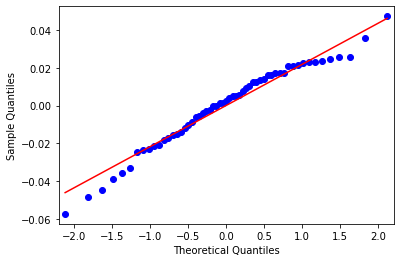

The mean of the residuals is -5.726e-16


In [31]:
# check normality of Residuals
import pylab
sm.qqplot(est.resid, line='s')
pylab.show()
mean_residuals = sum(est.resid)/len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [237]:
# Elliminate insignificant variables
#dataframe_remove_2 = dataframe_remove.drop('Humidity', axis=1)
#X = dataframe_remove_2.drop('NO_ppb', axis=1)
#print(X)
#y = dataframe_remove_2['NO_ppb']
#print(y)
# define output
#X2 = sm.add_constant(X)
# create model with OLS
#model_lin_reg_2 = sm.OLS(y, X)
# fir the data
#est = model_lin_reg_2.fit()
#print(est.summary())

# Polynomial Regression

In [33]:
poly_2 = PolynomialFeatures(degree=2, interaction_only=False,include_bias=False)
X_poly_2 = poly_2.fit_transform(X)
print(poly_2.get_feature_names())
model_poly_2 = LinearRegression(fit_intercept =False, normalize = True)

model_poly_2.fit(X_poly_2, y)
r_sq = model_poly_2.score(X_poly_2, y)
#print('coefficient of determination:', r_sq)
#print('intercept:', model_poly_2.intercept_)
#print('slope:', model_poly_2.coef_)
    
#X2_ = sm.add_constant(X_poly_2)
est = sm.OLS(y, X_poly_2).fit()
print(est.summary(xname=['Humidity', 'Temperature', 'CO_We', 'CO_Aux', 'Humidity^2', 'Humidity*Temperature', 'Humidity*CO_We', 'Humidity*CO_Aux','Temperature^2', 'Temperature*CO_We', 'Temperature*CO_Aux', 'CO_We^2','CO_We*CO_Aux', 'CO_Aux^2']))
#print(est.summary())

['x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2']
                            OLS Regression Results                            
Dep. Variable:                 CO ppm   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3181.
Date:                Fri, 16 Aug 2019   Prob (F-statistic):           4.84e-60
Time:                        22:13:27   Log-Likelihood:                 160.27
No. Observations:                  57   AIC:                            -292.5
Df Residuals:                      43   BIC:                            -263.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------